In [1]:
import scipy.io
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from model.utils import loadHSI,calculate_aligned_accuracy
from lund.utils import GraphExtractor, diffusion_distance
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from scipy.spatial.distance import pdist, squareform

Xmat = scipy.io.loadmat('X.mat')
Ymat = scipy.io.loadmat('Y.mat')

In [2]:
X_scipy = Xmat["X"]
GT_scipy = Ymat['Y']

In [3]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

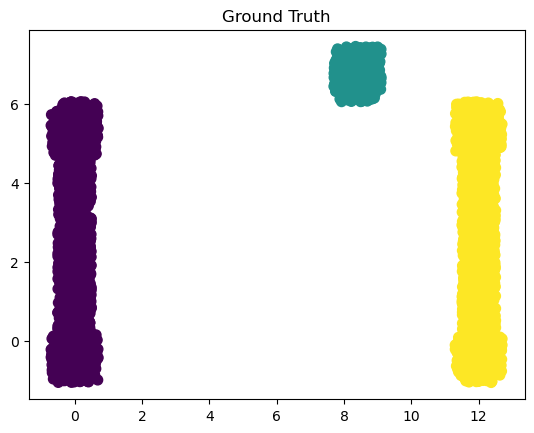

(6581, 2)


In [4]:
plot_clusters(X_scipy, GT_scipy, "Ground Truth")
print(X_scipy.shape)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Generate data for clusters
# # Left cluster
# cluster_1_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_1_y = np.random.normal(loc=3, scale=1.0, size=100)

# # Center cluster
# cluster_3_x = np.random.normal(loc=8, scale=0.2, size=100)
# cluster_3_y = np.random.normal(loc=6, scale=0.2, size=100)

# # Right cluster
# cluster_2_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_2_y = np.random.normal(loc=3, scale=1.0, size=100)

# # Combine x and y coordinates for each cluster into a single 2D array
# cluster_1 = np.column_stack((cluster_1_x, cluster_1_y))
# cluster_2 = np.column_stack((cluster_2_x, cluster_2_y))
# cluster_3 = np.column_stack((cluster_3_x, cluster_3_y))

# # Combine all clusters into one 2D array
# X = np.vstack((cluster_1, cluster_2, cluster_3))

# # Combine y coordinates for ground truth labels
# GT = np.hstack((cluster_1_y, cluster_2_y, cluster_3_y))

# # Create labels for clusters
# labels = np.array([0] * 100 + [1] * 100 + [2] * 100)

# # Plot the data with clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
# plt.title('Ground Truth')
# plt.xlim(-1, 14)
# plt.ylim(-1, 8)
# plt.show()

# print("X shape:", X.shape)
# print("GT shape:", GT.shape)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate data for the first cluster
# # left clusters
# cluster_1_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_1_y = np.random.normal(loc=4, scale=0.5, size=100)
# cluster_4_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_4_y = np.random.normal(loc=2, scale=0.5, size=100)

# # center cluster
# cluster_3_x = np.random.normal(loc=8, scale=0.2, size=100)
# cluster_3_y = np.random.normal(loc=6, scale=0.2, size=100)

# # Generate data for the second cluster
# # right clusters
# cluster_2_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_2_y = np.random.normal(loc=4, scale=0.5, size=100)
# cluster_5_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_5_y = np.random.normal(loc=2, scale=0.5, size=100)

# # Combine all clusters
# X = np.hstack((cluster_1_x, cluster_2_x, cluster_3_x, cluster_4_x, cluster_5_x))
# GT = np.hstack((cluster_1_y, cluster_2_y, cluster_3_y, cluster_4_y, cluster_5_y))

# # Create labels for clusters
# labels = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100)

# # Plot the data with clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X, GT, c=labels, cmap='viridis', s=50, edgecolor='k')
# plt.title('Ground Truth')
# plt.xlim(-1, 14)
# plt.ylim(-1, 8)
# plt.show()

# print(X.shape,'\n\n', GT.shape)

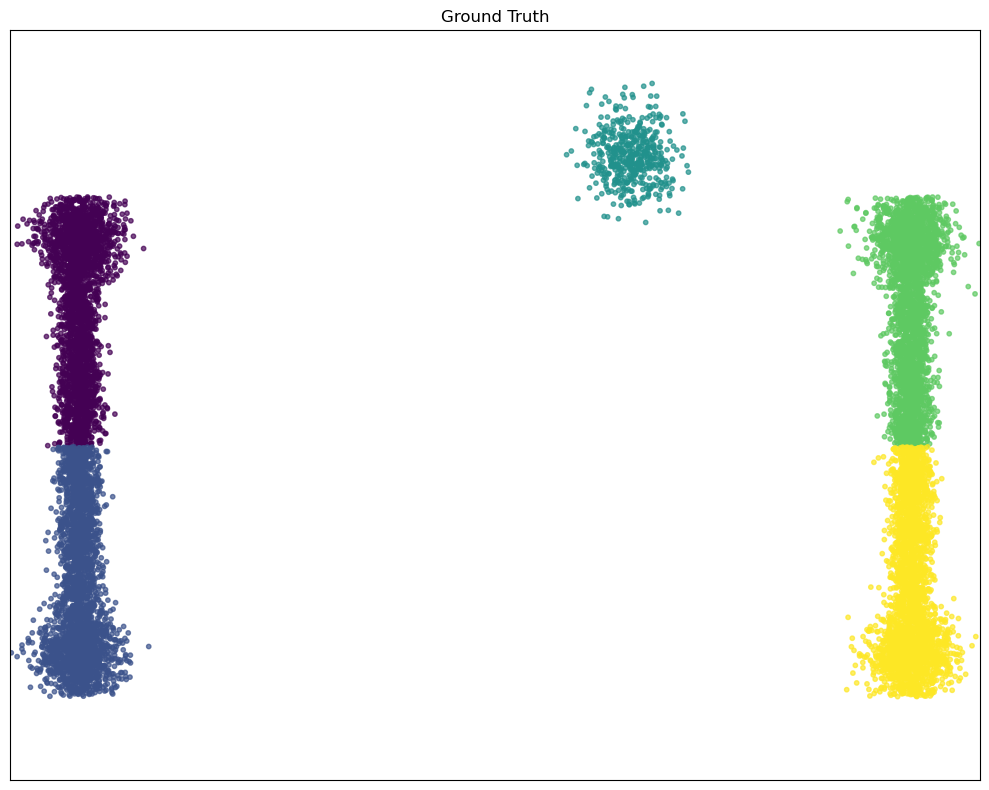

X shape: (11763, 2)
GT shape: (11763,)


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def generate_split_dumbbell_cluster(n_points, center, x_spread, y_spread, end_thickness):
    top_half = np.random.normal(loc=(center[0], center[1] + y_spread/2), 
                                scale=(x_spread, y_spread/2), 
                                size=(n_points//2, 2))
    bottom_half = np.random.normal(loc=(center[0], center[1] - y_spread/2), 
                                   scale=(x_spread, y_spread/2), 
                                   size=(n_points//2, 2))
    top_end = np.random.normal(loc=(center[0], center[1] + y_spread), 
                               scale=(x_spread * end_thickness, y_spread * 0.1), 
                               size=(n_points//4, 2))
    bottom_end = np.random.normal(loc=(center[0], center[1] - y_spread), 
                                  scale=(x_spread * end_thickness, y_spread * 0.1), 
                                  size=(n_points//4, 2))
    all_points = np.vstack((top_half, bottom_half, top_end, bottom_end))
    mask = (all_points[:, 1] >= center[1] - y_spread * 1.2) & (all_points[:, 1] <= center[1] + y_spread * 1.2)
    return all_points[mask]

def generate_compact_cluster(n_points, center, spread):
    return np.random.normal(loc=center, scale=spread, size=(n_points, 2))

def plot_ground_truth():
    left_dumbbell = generate_split_dumbbell_cluster(4000, center=(0, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    right_dumbbell = generate_split_dumbbell_cluster(4000, center=(12, 3), x_spread=0.15, y_spread=2.5, end_thickness=2)
    center_cluster = generate_compact_cluster(500, center=(8, 6.5), spread=0.3)
    
    left_top = left_dumbbell[left_dumbbell[:, 1] > 3]
    left_bottom = left_dumbbell[left_dumbbell[:, 1] <= 3]
    right_top = right_dumbbell[right_dumbbell[:, 1] > 3]
    right_bottom = right_dumbbell[right_dumbbell[:, 1] <= 3]
    
    # Combine all points into X
    X = np.vstack((left_top, left_bottom, center_cluster, right_top, right_bottom))
    
    # Create labels
    labels = np.concatenate([
        np.zeros(len(left_top)),
        np.ones(len(left_bottom)),
        np.full(len(center_cluster), 2),
        np.full(len(right_top), 3),
        np.full(len(right_bottom), 4)
    ])
    
    # Create GT (y-coordinates)
    GT = X[:, 1]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
    
    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 8)
    ax.set_title("Ground Truth")
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    plt.tight_layout()
    plt.show()
    
    return X, GT, labels

# Generate and plot data
X, GT, labels = plot_ground_truth()

tsne_X = TSNE(n_components=2, random_state=42)
X = tsne_X.fit_transform(X)

# Apply t-SNE to GT (reshape GT to 2D array)
# GT_2D = GT.reshape(-1, 1)
# tsne_GT = TSNE(n_components=2, random_state=42)
# GT = tsne_GT.fit_transform(GT_2D)


print("X shape:", X.shape)
print("GT shape:", GT.shape)

In [57]:
# Just subsample 10%

total_samples = X.shape[0]
subsample_size = int(total_samples * 0.1)  # 10% of the original data

# Generate random indices for subsampling
random_indices = np.random.choice(total_samples, subsample_size, replace=False)

# Subsample X and GT
X = X[random_indices]
GT = GT[random_indices]

print(f"X.shape: {X.shape}\nGT.shape: {GT.shape}")

X.shape: (2352, 2)
GT.shape: (2352,)


(2352, 2)
(2352,)
Initialized with NEigs = 2352 (type: <class 'int'>)


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


debugguing eigenvales length is  2352
(2352,) This is GT
entered lund
Number of Eigenvalues: 2352
Number of Eigenvectors: (2352, 2352)
Shape of G['EigenVecs']: (2352, 2352)
Shape of G['EigenVals']: (2352,)
Shape of DiffusionDistance: (2352, 2352)
Shape of p: (2352,)
m_sorting: [1644 1090   62 ... 1958 1589 1917]
Number of clusters K: 3
Aligned Accuracy: 0.23639455782312926


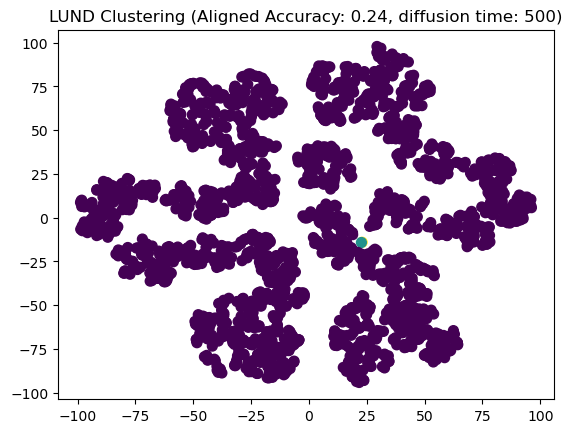

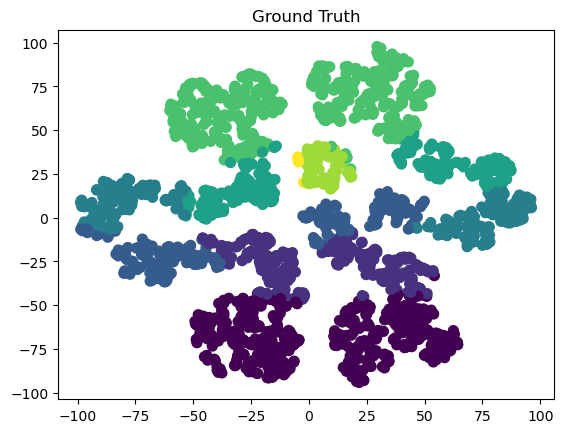

In [58]:
print(X.shape)
kde = KernelDensity(bandwidth=1.0).fit(X)
# kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10, NEigs=1174)
G = graph_extractor.extract_graph(X)


print(GT.shape, "This is GT")

# 500 is a good diffusion time
t = 500
C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, t, G, p)

GT = GT.astype(int)
C = C.astype(int)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f}, diffusion time: {t})")
plot_clusters(X, GT, "Ground Truth")

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
n_samples = 100
n_clusters = 3
centers = [(-5, -5), (0, 0), (5, 5)]
cluster_std = 0.5

# Generate points for each cluster
points = []
labels = []

for i, center in enumerate(centers):
    x = np.random.normal(center[0], cluster_std, n_samples // n_clusters)
    y = np.random.normal(center[1], cluster_std, n_samples // n_clusters)
    cluster_points = np.column_stack((x, y))
    points.append(cluster_points)
    labels.append(np.full(n_samples // n_clusters, i))

points = np.vstack(points)
labels = np.concatenate(labels)

df = pd.DataFrame(points, columns=['Feature1', 'Feature2'])
df['Label'] = labels
df_sorted = df.sort_values(by=['Feature1', 'Feature2']).reset_index(drop=True)

X = df_sorted[['Feature1', 'Feature2']].values
GT = df_sorted['Label'].values

plt.scatter(X[:, 0], X[:, 1], c=GT, cmap='viridis')
plt.title('Generated and Sorted Points')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

scipy.io.savemat('data.mat', {'X': X, 'GT': GT})


grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep, log_scale=False):
    if log_scale:
        timestep = np.log10(timestep)
    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at log10(t)={timestep:.2f}' if log_scale else f'Diffusion Distance Matrix at t={timestep}')
    plt.show()
    
# for timestep in [10, 40, 80, 100]:
#     print(f"Plotting for log10(t)={np.log10(timestep):.2f}")
#     plot_diffusion_distance(G, timestep, log_scale=False)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 150, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")